In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fid = drive.ListFile({'q':"title='StoreHouse.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('StoreHouse.zip')

In [4]:
from google.colab import files
files.os.listdir()

['datalab',
 '.config',
 '.forever',
 '.rnd',
 '.ipython',
 '.cache',
 'StoreHouse.zip',
 '.local']

In [0]:
import zipfile
with zipfile.ZipFile("StoreHouse.zip","r") as zip_ref:
    zip_ref.extractall()

In [6]:
files.os.listdir()

['datalab',
 '.config',
 '.forever',
 'StoreHouse',
 '.rnd',
 '.ipython',
 '.cache',
 'StoreHouse.zip',
 '.local']

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# Remember to enable GPU
%matplotlib inline


Using TensorFlow backend.


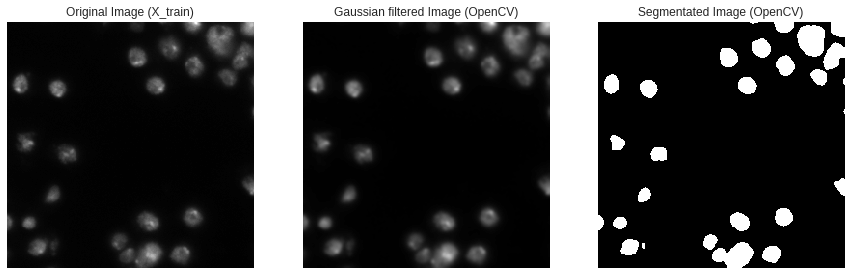

In [8]:
def openCVdemo():
    ID = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
    FILE = "StoreHouse/stage1_train/{}/images/{}.png".format(ID,ID)
    img = cv2.imread(FILE,0)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    # Plot Here
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image (X_train)','Gaussian filtered Image (OpenCV)',"Segmentated Image (OpenCV)"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])
openCVdemo()

In [9]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.0MB/s 


In [0]:
from tqdm import tqdm

In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [0]:
TRAIN_PATH = "StoreHouse/stage1_train/"
TEST_PATH = "StoreHouse/stage1_test/"

In [13]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk(TEST_PATH):
    print("die")
    f.extend(filenames)
    print(filenames)


die
[]
die
[]
die
['53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4.png']
die
[]
die
['f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4.png']
die
[]
die
['912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406.png']
die
[]
die
['43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af.png']
die
[]
die
['eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835.png']
die
[]
die
['fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f.png']
die
[]
die
['1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b.png']
die
[]
die
['3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26.png']
die
[]
die
['259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4.png']
die
[]
die
['31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a.png']
die
[]
die
['d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896.png']
die
[]
die
['7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3

In [0]:
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [0]:
X_train=np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
Y_train=np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1), dtype=np.bool)

In [17]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
X_test=np.zeros((len(test_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
    

 11%|█         | 75/670 [00:09<01:18,  7.62it/s]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 670/670 [01:48<00:00,  6.15it/s]

Getting and resizing test images ... 


In [18]:
for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
  
  path = TEST_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = img
print('Done!')


100%|██████████| 65/65 [00:00<00:00, 69.90it/s]

Done!


In [19]:
print(sizes_test)

[[256, 256], [520, 696], [256, 256], [260, 347], [519, 253], [256, 256], [512, 640], [524, 348], [512, 680], [256, 256], [520, 348], [256, 256], [256, 256], [520, 348], [512, 640], [256, 256], [260, 347], [512, 680], [256, 256], [519, 253], [256, 256], [520, 696], [519, 253], [256, 256], [256, 256], [512, 680], [519, 162], [390, 239], [512, 640], [512, 640], [256, 256], [256, 256], [524, 348], [520, 348], [512, 680], [256, 256], [512, 640], [256, 256], [256, 256], [512, 680], [519, 253], [260, 347], [256, 256], [256, 256], [524, 348], [256, 256], [512, 680], [520, 696], [260, 347], [519, 161], [512, 680], [256, 256], [519, 161], [256, 256], [256, 256], [524, 348], [512, 680], [512, 640], [520, 696], [256, 256], [256, 256], [519, 162], [520, 348], [512, 640], [512, 640]]


In [20]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)


x_train (536, 128, 128, 3)
x_test (134, 128, 128, 3)
y_train (536, 128, 128, 1)
y_test (134, 128, 128, 1)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


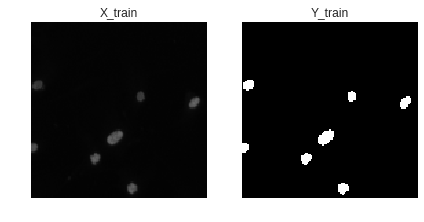

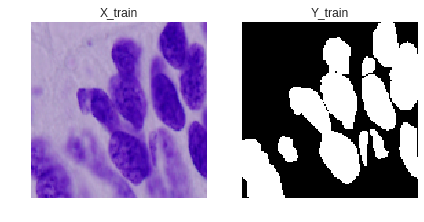

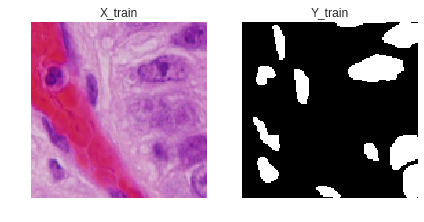

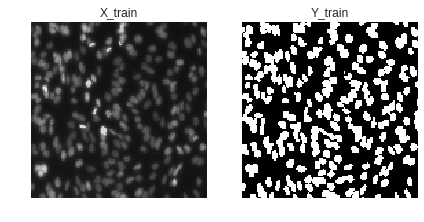

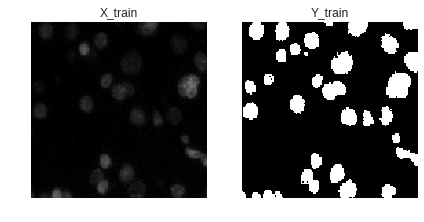

In [21]:
def plotTrainData(a,b):
  for i in range(5):
    ix = random.randint(0, len(train_ids))
    plt.subplot(1,2,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(a[ix])
    print
    plt.subplot(1,2,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.show()
    
     
plotTrainData(X_train,Y_train)

In [0]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [0]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [24]:
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (128, 128, IMG_CHANNELS),name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    # use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
    # the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()
#checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
#earlystopper = EarlyStopping(patience=5, verbose=1)
simple_cnn.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                      metrics=['accuracy'])
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 16)      528       
__________

In [25]:
history = simple_cnn.fit(x_train,y_train, validation_data=(x_test,y_test),epochs = 30)
 

Train on 536 samples, validate on 134 samples
Epoch 1/30
536/536 [==============================] - 5s 9ms/step - loss: 0.6308 - acc: 0.7333 - val_loss: 0.5146 - val_acc: 0.8501
Epoch 2/30
536/536 [==============================] - 2s 4ms/step - loss: 0.4255 - acc: 0.8508 - val_loss: 0.3750 - val_acc: 0.8515
Epoch 3/30
536/536 [==============================] - 2s 4ms/step - loss: 0.3687 - acc: 0.8593 - val_loss: 0.3693 - val_acc: 0.8481
Epoch 4/30
536/536 [==============================] - 2s 4ms/step - loss: 0.3467 - acc: 0.8654 - val_loss: 0.3329 - val_acc: 0.8707
Epoch 5/30
536/536 [==============================] - 2s 4ms/step - loss: 0.3258 - acc: 0.8756 - val_loss: 0.3215 - val_acc: 0.8797
Epoch 6/30
536/536 [==============================] - 2s 4ms/step - loss: 0.3065 - acc: 0.8858 - val_loss: 0.3042 - val_acc: 0.8876
Epoch 7/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2936 - acc: 0.8934 - val_loss: 0.2921 - val_acc: 0.8979
Epoch 8/30
536/536 [==========

536/536 [==============================] - 2s 4ms/step - loss: 0.2779 - acc: 0.9019 - val_loss: 0.2820 - val_acc: 0.8987
Epoch 10/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2705 - acc: 0.9058 - val_loss: 0.2692 - val_acc: 0.9056
Epoch 11/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2738 - acc: 0.9056 - val_loss: 0.2704 - val_acc: 0.9073
Epoch 12/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2634 - acc: 0.9066 - val_loss: 0.2646 - val_acc: 0.9093
Epoch 13/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2605 - acc: 0.9103 - val_loss: 0.2625 - val_acc: 0.9082
Epoch 14/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2569 - acc: 0.9116 - val_loss: 0.2579 - val_acc: 0.9116
Epoch 15/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2512 - acc: 0.9126 - val_loss: 0.2531 - val_acc: 0.9154
Epoch 16/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2519

536/536 [==============================] - 2s 4ms/step - loss: 0.2463 - acc: 0.9149 - val_loss: 0.2513 - val_acc: 0.9170
Epoch 19/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2414 - acc: 0.9199 - val_loss: 0.2514 - val_acc: 0.9167
Epoch 20/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2415 - acc: 0.9189 - val_loss: 0.2482 - val_acc: 0.9178
Epoch 21/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2390 - acc: 0.9211 - val_loss: 0.2500 - val_acc: 0.9171
Epoch 22/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2408 - acc: 0.9215 - val_loss: 0.2445 - val_acc: 0.9169
Epoch 23/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2407 - acc: 0.9195 - val_loss: 0.2482 - val_acc: 0.9199
Epoch 24/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2370 - acc: 0.9219 - val_loss: 0.2444 - val_acc: 0.9216
Epoch 25/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2353

536/536 [==============================] - 2s 4ms/step - loss: 0.2381 - acc: 0.9218 - val_loss: 0.2440 - val_acc: 0.9249
Epoch 28/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2332 - acc: 0.9249 - val_loss: 0.2432 - val_acc: 0.9217
Epoch 29/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2324 - acc: 0.9245 - val_loss: 0.2422 - val_acc: 0.9240
Epoch 30/30
536/536 [==============================] - 2s 4ms/step - loss: 0.2301 - acc: 0.9262 - val_loss: 0.2394 - val_acc: 0.9217


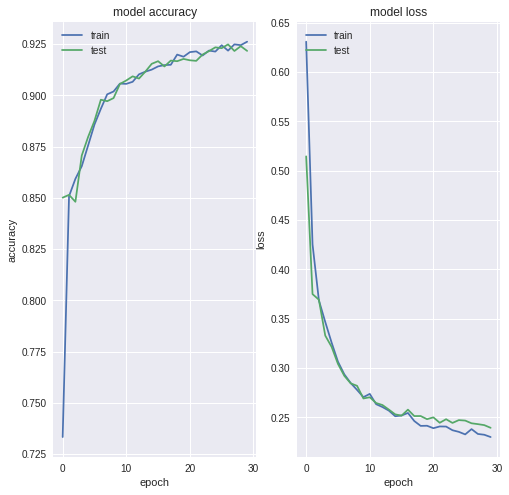

In [26]:
plot_learning_curve(history)
plt.show()

plt.show()
global modelY
modelY = simple_cnn

In [31]:
from google.colab import files

uploaded = files.upload()

Saving desuKa.jpg to desuKa.jpg


In [30]:
os.listdir()

['datalab',
 '.config',
 'loss_curve.png',
 '.forever',
 'StoreHouse',
 '.keras',
 '.nv',
 '.rnd',
 'accuracy_curve.png',
 '.ipython',
 '.cache',
 'StoreHouse.zip',
 '.local']

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


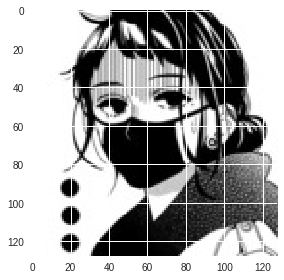

In [32]:
x=cv2.imread('desuKa.jpg')
imshow(x)

In [33]:

x.shape
x = cv2.resize(x, (128, 128)) 

y=[x]
y=np.array(y)
y.shape

(1, 128, 128, 3)

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [0]:
u=modelY.predict(y)
u.shape
u=u.reshape(128,128)

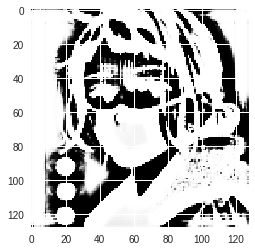

In [35]:
plt.imshow(u)

In [0]:
#UNET

In [183]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
    # Fit model
     
     
 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 

In [184]:
results = model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs = 30)

Train on 536 samples, validate on 134 samples
Epoch 1/30
128/536 [======>.......................] - ETA: 11s - loss: 0.6211 - acc: 0.6591

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


536/536 [==============================] - 8s 15ms/step - loss: 0.5404 - acc: 0.7901 - val_loss: 0.4826 - val_acc: 0.8183
Epoch 2/30
536/536 [==============================] - 4s 8ms/step - loss: 0.4249 - acc: 0.8507 - val_loss: 0.4385 - val_acc: 0.8256
Epoch 3/30
536/536 [==============================] - 4s 8ms/step - loss: 0.3715 - acc: 0.8553 - val_loss: 0.3837 - val_acc: 0.8289
Epoch 4/30
536/536 [==============================] - 4s 8ms/step - loss: 0.2615 - acc: 0.8961 - val_loss: 0.2757 - val_acc: 0.8901
Epoch 5/30
536/536 [==============================] - 4s 8ms/step - loss: 0.2059 - acc: 0.9194 - val_loss: 0.2764 - val_acc: 0.8934
Epoch 6/30
536/536 [==============================] - 4s 8ms/step - loss: 0.1767 - acc: 0.9317 - val_loss: 0.1799 - val_acc: 0.9250
Epoch 7/30
536/536 [==============================] - 4s 8ms/step - loss: 0.1501 - acc: 0.9419 - val_loss: 0.1684 - val_acc: 0.9323
Epoch 8/30
536/536 [==============================] - 4s 8ms/step - loss: 0.1335 - acc

536/536 [==============================] - 4s 8ms/step - loss: 0.1185 - acc: 0.9540 - val_loss: 0.1318 - val_acc: 0.9458
Epoch 11/30
536/536 [==============================] - 4s 8ms/step - loss: 0.1103 - acc: 0.9573 - val_loss: 0.1301 - val_acc: 0.9480
Epoch 12/30
536/536 [==============================] - 4s 8ms/step - loss: 0.1049 - acc: 0.9595 - val_loss: 0.1276 - val_acc: 0.9491
Epoch 13/30
536/536 [==============================] - 4s 8ms/step - loss: 0.1024 - acc: 0.9604 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 14/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0988 - acc: 0.9618 - val_loss: 0.1221 - val_acc: 0.9522
Epoch 15/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0979 - acc: 0.9618 - val_loss: 0.1196 - val_acc: 0.9511
Epoch 16/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0947 - acc: 0.9632 - val_loss: 0.1063 - val_acc: 0.9573
Epoch 17/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0940

536/536 [==============================] - 4s 8ms/step - loss: 0.0922 - acc: 0.9642 - val_loss: 0.1055 - val_acc: 0.9592
Epoch 20/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0903 - acc: 0.9648 - val_loss: 0.1086 - val_acc: 0.9564
Epoch 21/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0896 - acc: 0.9649 - val_loss: 0.1053 - val_acc: 0.9580
Epoch 22/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0885 - acc: 0.9655 - val_loss: 0.1081 - val_acc: 0.9574
Epoch 23/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0862 - acc: 0.9664 - val_loss: 0.1001 - val_acc: 0.9595
Epoch 24/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0862 - acc: 0.9661 - val_loss: 0.0995 - val_acc: 0.9594
Epoch 25/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0847 - acc: 0.9666 - val_loss: 0.0988 - val_acc: 0.9608
Epoch 26/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0832

536/536 [==============================] - 4s 8ms/step - loss: 0.0811 - acc: 0.9680 - val_loss: 0.0935 - val_acc: 0.9619
Epoch 29/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0808 - acc: 0.9680 - val_loss: 0.0949 - val_acc: 0.9617
Epoch 30/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0839 - acc: 0.9671 - val_loss: 0.1356 - val_acc: 0.9450


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


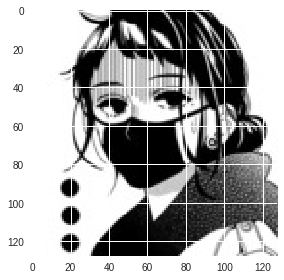

In [192]:

x=cv2.imread('desuKa (1).jpg')
imshow(x)

In [193]:
x.shape
x = cv2.resize(x, (128, 128)) 

y=[x]
y=np.array(y)
y.shape

(1, 128, 128, 3)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


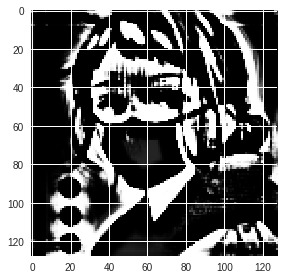

In [194]:
u=modelY.predict(y)
u.shape
u=u.reshape(128,128)
imshow(u)